# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas as pd
from scipy.linalg import cholesky
from KalmanFilters import UKF

# Testfall

$$\mathbf x = \begin{bmatrix}\mathtt{x} \\\mathtt{y} \\\mathtt{velocity}\\ \mathtt{angle} \\ \mathtt{angle per second}\end{bmatrix}=    \begin{bmatrix}x \\ y \\ v \\ \theta \\ \dot{\theta}\end{bmatrix}$$

In [2]:
dt = .04
dim_x = 5
kappa = 1.
init_state = np.array([0, 0, .0, 0, 0]) #x_pos, y_pos, v, theta, theta_dot

$$\dot{x} = v \cos(\theta)$$
$$\dot{y} = v \sin(\theta)$$
$$\dot{v} = 0$$
$$\dot{\theta} = \dot{\theta}$$
$$\ddot{\theta} = 0$$

$$x_{t+1} = x_t+v_tcos(\theta_t)\Delta t$$
$$y_{t+1} = y_t+v_tsin(\theta_t)\Delta t$$
$$v_{t+1} = v_t$$
$$\theta_{t+1} = \theta_t + \dot{\theta_t}\Delta t$$
$$\dot{\theta}_{t+1} = \dot{\theta_t}$$

In [3]:
def f(x, t):
    x_prior = np.empty_like(x)

    x_pos = x[0]
    y_pos = x[1]
    v = x[2]
    theta = x[3]
    theta_dot = x[4]

    x_prior[0] = x_pos + v * np.cos(theta) * f.dt
    x_prior[1] = y_pos + v * np.sin(theta) * f.dt
    x_prior[2] = v
    x_prior[3] = theta + theta_dot * f.dt
    x_prior[4] = theta_dot

    return x_prior
f.dt = dt

In [4]:
Q = np.eye(dim_x)
Q[:2,:2] = Q[:2,:2] * dt
Q[3,3] = dt

init_cov_matrix = np.array([.1**2,      0,      0,      0,      0,
                                    .1**2,      0,      0,      0,
                                             .5**2,      0,      0,
                                                     .5**2,      0,
                                                             .1**2])

$$
z = \begin{bmatrix}
heading_{gyro} \\
heading_{magneto} \\
heading_{odometry} \\
heading_{vision} \\
x_{odometry} \\
y_{odometry} \\
x_{vision} \\
y_{vision} \\
x_{efference} \\
y_{efference} \\
\end{bmatrix}
$$

In [5]:
dim_z = 10

$$
h(\mathbf x) = 
\begin{cases} 
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
\frac{180}{\pi} \theta \\
x \\
y \\
x \\
y \\
x \\
y \\
\end{cases}
$$

In [6]:
def h(x):
    x_pos = x[0]
    y_pos = x[1]
    theta = x[3]
    theta_degrees = theta * (180 / np.pi)
    return np.array([theta_degrees, theta_degrees, theta_degrees, theta_degrees, x_pos, y_pos, x_pos, y_pos, x_pos, y_pos]).reshape((dim_z,))

$$
R = \begin{bmatrix}
\sigma_{heading_{gyro}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & \sigma_{heading_{magneto}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_{heading_{odometry}}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_{heading_{vision}}^2 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_{x_{odometry}}^2 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{y_{odometry}}^2 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sigma_{x_{vision}}^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{y_{vision}}^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{x_{efference}}^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{y_{efference}}^2 \\
\end{bmatrix}
$$

In [7]:
heading_gyro_std = 1.
heading_magneto_std =1.
heading_odometry_std = 1.
heading_vision_std = 1.
x_odometry_std = .1
y_odometry_std = .1
x_vision_std = .1
y_vision_std = .1
x_efference_std = .1
y_efference_std = .1
R = np.diag([heading_gyro_std**2, heading_magneto_std**2, heading_odometry_std**2, heading_vision_std**2, 
             x_odometry_std**2, y_odometry_std**2, x_vision_std**2, y_vision_std**2, x_efference_std**2, y_efference_std**2])

# Messwerte

In [8]:
df_heading = pd.read_csv('./heading_data.csv')
df_position = pd.read_csv('./position_data.csv')
df = pd.merge(df_heading, df_position, left_index=True, right_index=True)
df.sample()

,head_gyro,head_magneto,head_odometry,head_vision,x_odometry,y_odometry,x_vision,y_vision,x_efference,y_efference
775,81.286668,64.572,85.84189,82.215527,0.15517,0.647378,0.131034,0.809245,0.154732,0.71857


In [9]:
zs = df.to_numpy()

# Klassisch

In [10]:
min = 99999
max = -99999

In [11]:
W = np.full(2*dim_x+1, 1. / (2 * (dim_x + kappa)))
W[0] = kappa / (dim_x + kappa)

In [12]:
def compute_sigmas(x, P, min, max):
    sigmas = np.zeros((2*dim_x+1, dim_x))
    U = cholesky((dim_x + kappa) * P)

    U_min = np.min(U)
    U_max = np.max(U)
    if U_min < min:
        min = U_min
    if U_max > max:
        max = U_max

    sigmas[0] = x
    for i in range(dim_x):
        sigmas[i+1] = np.subtract(x, -U[i])
        sigmas[dim_x+i+1] = np.subtract(x, U[i])
    return (sigmas, min, max)

In [13]:
def unscented_transform(sigmas, W, noise):
    mean = W @ sigmas
    residual = sigmas - mean[np.newaxis, :]
    cov = residual.T @ (np.diag(W) @ residual) + noise
    return (mean, cov)

In [14]:
x = np.copy(init_state)
P = np.array([[.1**2,      0,     0,      0,      0],
              [     0, .1**2,     0,      0,      0],
              [     0,      0, .5**2,      0,      0],
              [     0,      0,     0, .5**2,      0],
              [     0,      0,     0,      0, .1**2]])

xs, cov = [], []

sigmas = sigmas_f = np.zeros((2*dim_x+1, dim_x))
sigmas_h = np.zeros((2*dim_x+1, dim_z))

for z in zs:
    sigmas, min, max = compute_sigmas(x, P, min, max)
    for i, s in enumerate(sigmas):
        sigmas_f[i] = f(s, None)
    x, P = unscented_transform(sigmas_f, W, Q)
    sigmas_f, min, max = compute_sigmas(x, P, min, max)
    
    for i, s in enumerate(sigmas_f):
        sigmas_h[i] = h(s)
    zp, S = unscented_transform(sigmas_h, W, R)
    Pxz = np.zeros((dim_x, dim_z))
    for i in range(2*dim_x+1):
        dx = np.subtract(sigmas_f[i], x)
        dz = np.subtract(sigmas_h[i], zp)
        Pxz += W[i] * np.outer(dx, dz)
    K = Pxz @ np.linalg.inv(S)
    y = np.subtract(z, zp)
    x += K @ y
    P -= K @ S @ K.T

    xs.append(x)
    cov.append(P)

xs = np.asarray(xs)
cov = np.asarray(cov)

In [15]:
print(f'min: {min}')
print(f'max: {max}')

min: -2.525050560558926
max: 5.761048676596498


(-1.0, 1.0)

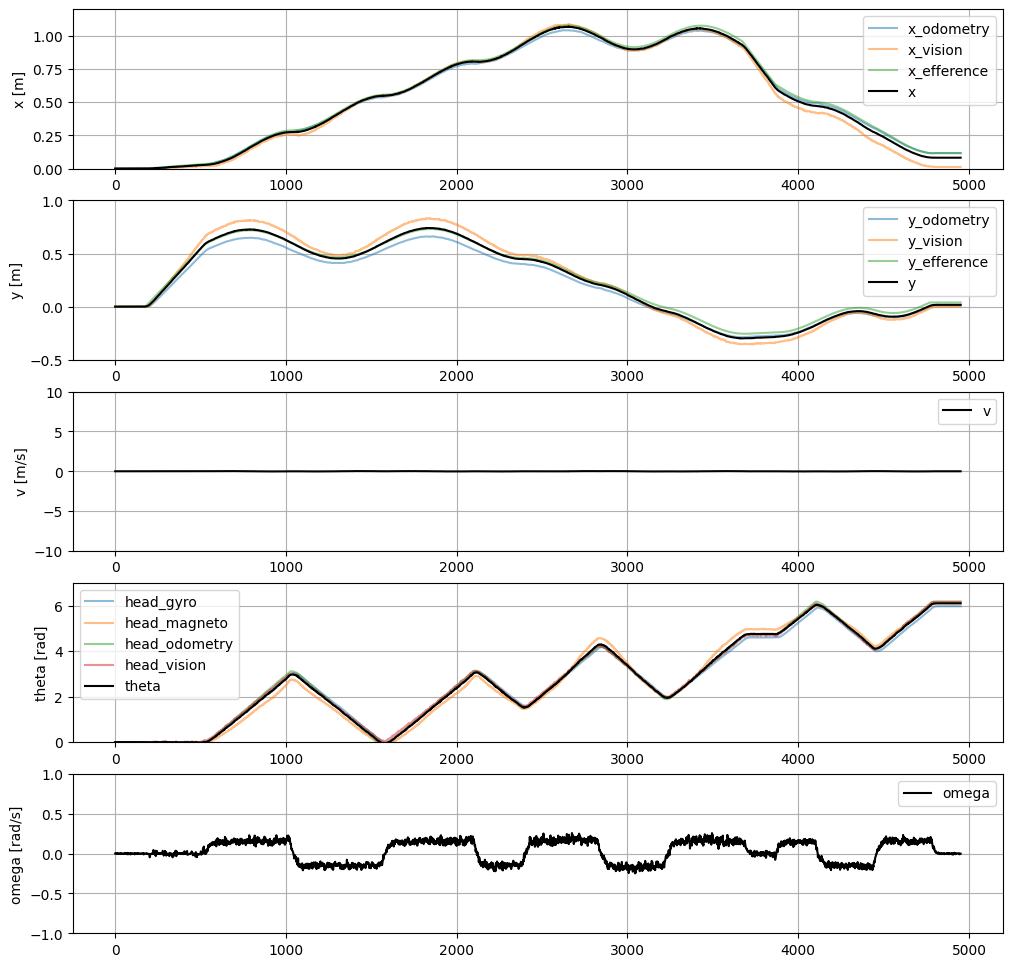

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(df['x_odometry'], label='x_odometry', alpha=.5)
plt.plot(df['x_vision'], label='x_vision', alpha=.5)
plt.plot(df['x_efference'], label='x_efference', alpha=.5)
plt.plot(xs[:, 0], c="black", label="x")
plt.ylabel("x [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 1.2)

plt.subplot(5, 1, 2)
plt.plot(df['y_odometry'], label='y_odometry', alpha=.5)
plt.plot(df['y_vision'], label='y_vision', alpha=.5)
plt.plot(df['y_efference'], label='y_efference', alpha=.5)
plt.plot(xs[:, 1], c="black", label="y")
plt.ylabel("y [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.5, 1)

plt.subplot(5, 1, 3)
plt.plot(xs[:, 2], c="black", label="v")
plt.ylabel("v [m/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-10, 10)

plt.subplot(5, 1, 4)
plt.plot(df['head_gyro'] * np.pi / 180, label='head_gyro', alpha=.5)
plt.plot(df['head_magneto'] * np.pi / 180, label='head_magneto', alpha=.5)
plt.plot(df['head_odometry'] * np.pi / 180, label='head_odometry', alpha=.5)
plt.plot(df['head_vision'] * np.pi / 180, label='head_vision', alpha=.5)
plt.plot(xs[:, 3], c="black", label="theta")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 7)

plt.subplot(5, 1, 5)
plt.plot(xs[:, 4], c="black", label="omega")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 1)

(-0.5, 1.0)

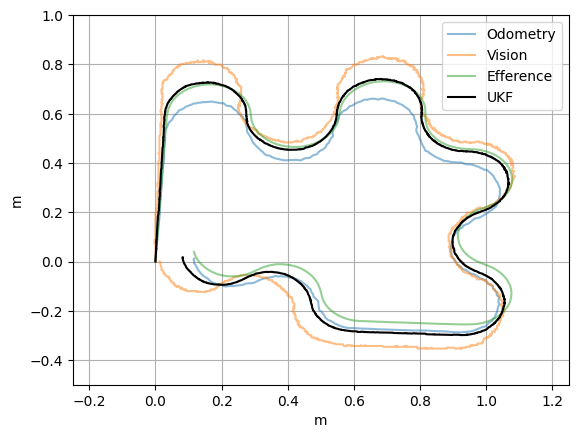

In [17]:
plt.subplot(1, 1, 1)
plt.plot(df['x_odometry'], df['y_odometry'], label="Odometry", alpha=.5)
plt.plot(df['x_vision'], df['y_vision'], label="Vision", alpha=.5)
plt.plot(df['x_efference'], df['y_efference'], label="Efference", alpha=.5)
plt.plot(xs[:, 0], xs[:, 1], c="black", label="UKF")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

(0.0, 25.0)

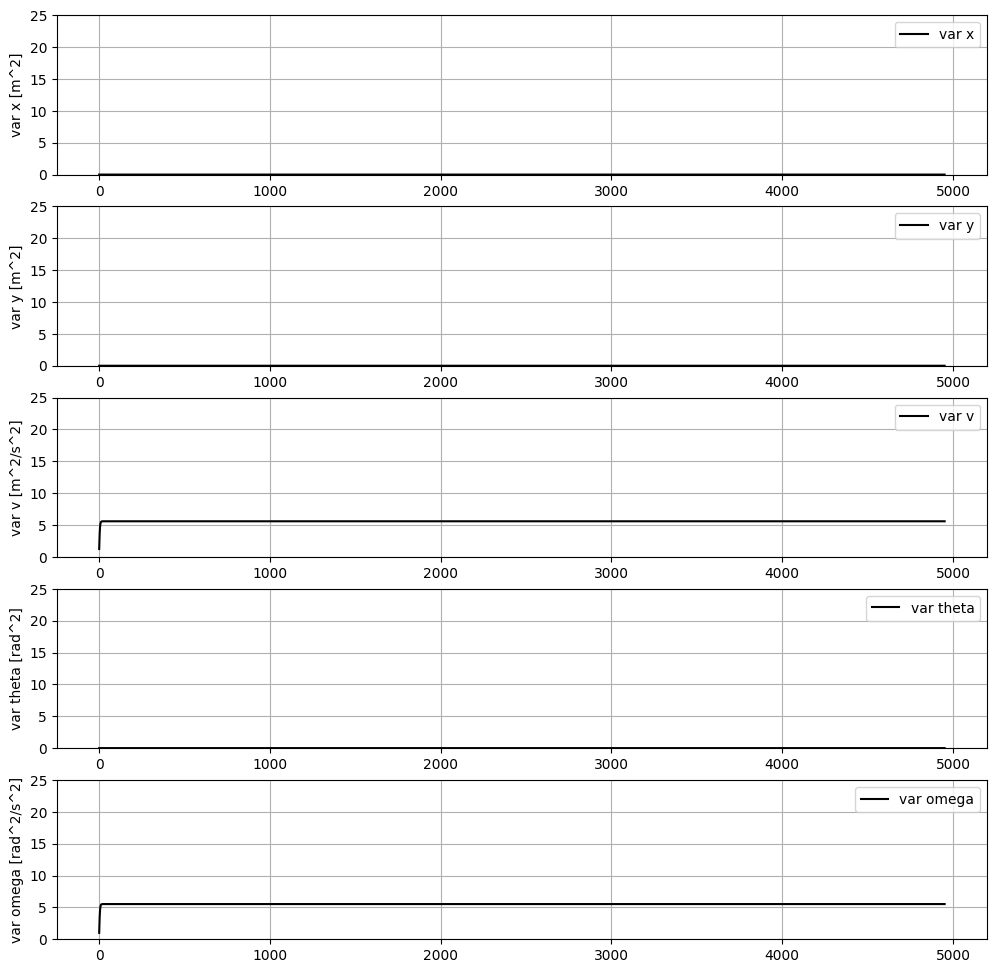

In [18]:
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(cov[:, 0, 0], c="black", label="var x")
plt.ylabel("var x [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 25)

plt.subplot(5, 1, 2)
plt.plot(cov[:, 1, 1], c="black", label="var y")
plt.ylabel("var y [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 25)

plt.subplot(5, 1, 3)
plt.plot(cov[:, 2, 2], c="black", label="var v")
plt.ylabel("var v [m^2/s^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 25)

plt.subplot(5, 1, 4)
plt.plot(cov[:, 3, 3], c="black", label="var theta")
plt.ylabel("var theta [rad^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 25)

plt.subplot(5, 1, 5)
plt.plot(cov[:, 4, 4], c="black", label="var omega")
plt.ylabel("var omega [rad^2/s^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 25)

# Nengo

In [19]:
ukf = UKF(dim_x=dim_x, dim_z=dim_z, dt=dt, f=f, Q=Q, h=h, R=R, kappa=kappa)

In [20]:
ukf.initial_x = init_state
ukf.initial_P = init_cov_matrix
ukf.simulation_runtime= 200.
#ukf.connection_synapse = .1
ukf.x_radius = 7
#ukf.P_max_rates = nengo.dists.Uniform(300, 500)
#ukf.x_intercepts = nengo.dists.Uniform(-1., 1.)
ukf.P_radius = 7
ukf.P_intercepts = nengo.dists.Uniform(0, 1.)
ukf.P_encoders = nengo.dists.Choice([[1]])

In [21]:
probes = ukf.build_model_for_measurements(zs).execute().get_probes()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/nengo/node.py:62: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  warnings.warn(


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


/Users/tobi/Desktop/spiking-sensor-fusion/ukf.py:18: RuntimeWarning: overflow encountered in matmul
  cov = y.T @ np.diag(self._W) @ y + noise
/Users/tobi/Desktop/spiking-sensor-fusion/ukf.py:52: RuntimeWarning: overflow encountered in multiply
  U = cholesky((self._dim_x + self._kappa) * self._P)


RuntimeError: Error while executing Kalman-Filter: array must not contain infs or NaNs

(-1.0, 15.0)

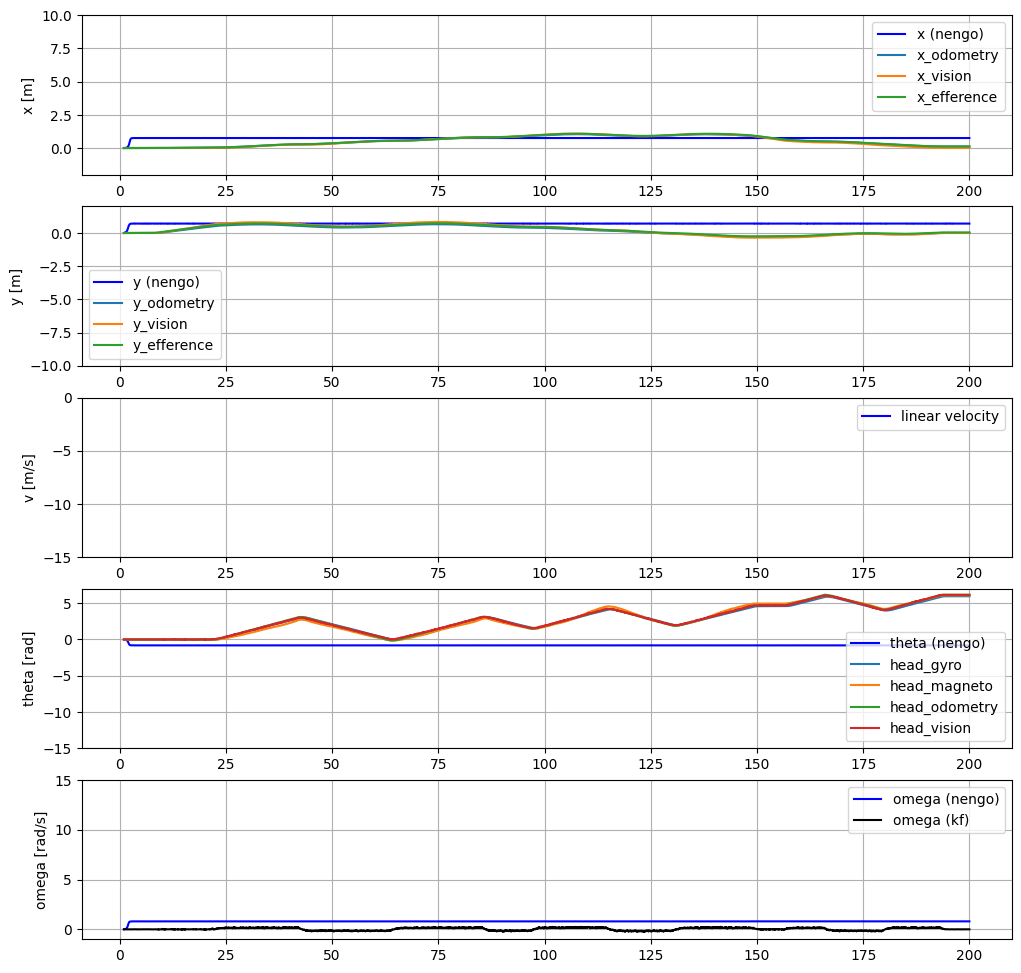

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(np.linspace(1,200,5000), probes['x'].T[0], c="b", label="x (nengo)")
#plt.plot(np.linspace(1,200,4952), xs[:, 0], c="black", label="x (kf)")
plt.plot(np.linspace(1,200,4952), df['x_odometry'], label='x_odometry')
plt.plot(np.linspace(1,200,4952), df['x_vision'], label='x_vision')
plt.plot(np.linspace(1,200,4952), df['x_efference'], label='x_efference')
plt.ylabel("x [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-2, 10)

plt.subplot(5, 1, 2)
plt.plot(np.linspace(1,200,5000), probes['x'].T[1], c="b", label="y (nengo)")
#plt.plot(np.linspace(1,200,4952), xs[:, 1], c="black", label="y (kf)")
plt.plot(np.linspace(1,200,4952), df['y_odometry'], label='y_odometry')
plt.plot(np.linspace(1,200,4952), df['y_vision'], label='y_vision')
plt.plot(np.linspace(1,200,4952), df['y_efference'], label='y_efference')
plt.ylabel("y [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-10, 2)

plt.subplot(5, 1, 3)
plt.plot(np.linspace(1,200,5000), probes['x'].T[2], c="b", label="linear velocity")
plt.ylabel("v [m/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-15, 0)

plt.subplot(5, 1, 4)
plt.plot(np.linspace(1,200,5000), probes['x'].T[3], c="b", label="theta (nengo)")
#plt.plot(np.linspace(1,200,4952), xs[:, 3], c="black", label="theta (kf)")
plt.plot(np.linspace(1,200,4952), df['head_gyro'] * np.pi / 180, label='head_gyro')
plt.plot(np.linspace(1,200,4952), df['head_magneto'] * np.pi / 180, label='head_magneto')
plt.plot(np.linspace(1,200,4952), df['head_odometry'] * np.pi / 180, label='head_odometry')
plt.plot(np.linspace(1,200,4952), df['head_vision'] * np.pi / 180, label='head_vision')
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-15, 7)

plt.subplot(5, 1, 5)
plt.plot(np.linspace(1,200,5000), probes['x'].T[4], c="b", label="omega (nengo)")
plt.plot(np.linspace(1,200,4952), xs[:, 4], c="black", label="omega (kf)")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 15)

(0.0, 10.0)

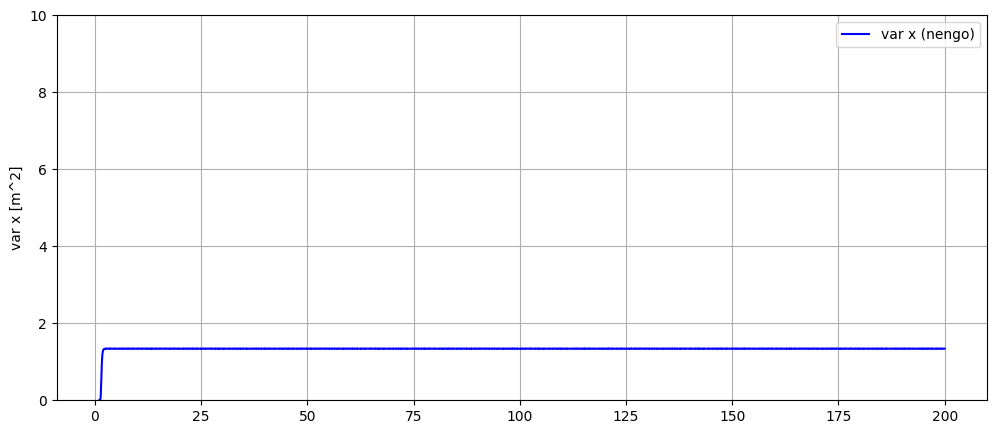

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
plt.plot(np.linspace(1,200,5000), probes['P'].T[0], c="b", label="var x (nengo)")
plt.ylabel("var x [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 10)

In [ ]:
min = probes['min']
max = probes['max']

print(f'min: {min}')
print(f'max: {max}')

min: -307.32715128856694
max: 366.3611802608874


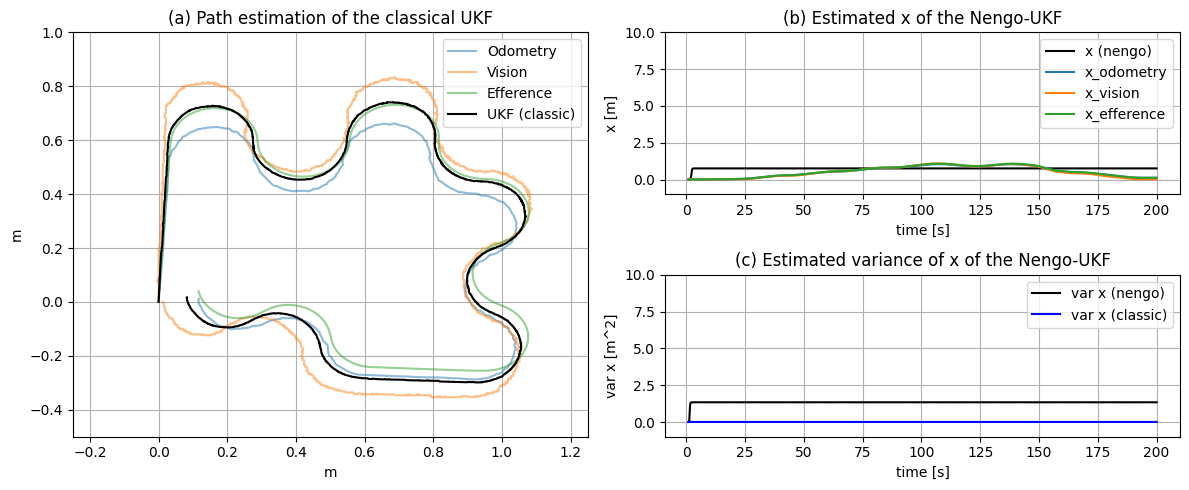

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot2grid((2, 2), (0, 0), rowspan=2)
plt.title('(a) Path estimation of the classical UKF')
plt.plot(df['x_odometry'], df['y_odometry'], label="Odometry", alpha=.5)
plt.plot(df['x_vision'], df['y_vision'], label="Vision", alpha=.5)
plt.plot(df['x_efference'], df['y_efference'], label="Efference", alpha=.5)
plt.plot(xs[:, 0], xs[:, 1], c="black", label="UKF (classic)")
plt.xlabel("m")
plt.ylabel("m")
plt.grid()
plt.legend(loc="best")
plt.xlim(-.25, 1.25)
plt.ylim(-.5, 1)

plt.subplot2grid((2, 2), (0, 1))
plt.title('(b) Estimated x of the Nengo-UKF')
plt.plot(np.linspace(1,200,5000), probes['x'].T[0], c="black", label="x (nengo)")
plt.plot(np.linspace(1,200,4952), df['x_odometry'], label='x_odometry')
plt.plot(np.linspace(1,200,4952), df['x_vision'], label='x_vision')
plt.plot(np.linspace(1,200,4952), df['x_efference'], label='x_efference')
plt.xlabel("time [s]")
plt.ylabel("x [m]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 10)

plt.subplot2grid((2, 2), (1, 1))
plt.title('(c) Estimated variance of x of the Nengo-UKF')
plt.plot(np.linspace(1,200,5000), probes['P'].T[0], c="black", label="var x (nengo)")
plt.plot(np.linspace(1,200,4952), cov[:, 0, 0], c="b", label="var x (classic)")
plt.xlabel("time [s]")
plt.ylabel("var x [m^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-1, 10)

plt.tight_layout()
plt.subplots_adjust(wspace=.15)
plt.show()